In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as f
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/Users/sonnguyen/anaconda3/envs/gcnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = pd.read_csv("mitbih_train.csv").to_numpy()
X_test = pd.read_csv("mitbih_test.csv").to_numpy()

Y_train = X_train[67000:,-1].astype(int)
Y_test = X_test[:,-1].astype(int)
X_train = X_train[67000:,:-1]
X_test = X_test[:,:-1]

In [5]:
class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(32, 32, 5, padding='same')
        init.xavier_uniform_(self.conv1.weight)
        init.constant_(self.conv1.bias, 0)
        self.conv2 = nn.Conv1d(32, 32, 5, padding='same')
        init.xavier_uniform_(self.conv2.weight)
        init.constant_(self.conv2.bias, 0)
        self.pool = nn.MaxPool1d(5,stride=2)
        
    def forward(self, data):
        output = f.relu(self.conv1(data))
        output = self.conv2(output)
        output = output + data
        output = f.relu(output)
        output = self.pool(output)
        return output
    
class implementedModel(nn.Module):
    def __init__(self, device):
        super(implementedModel, self).__init__()
        self.preconv = nn.Conv1d(1, 32, 5, padding='same')
        init.xavier_uniform_(self.preconv.weight)
        init.constant_(self.preconv.bias, 0)
        self.res = []
        for i in range(5):
            self.res.append(ResBlock().to(device))
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 5)
        
        
    def forward(self, data):
        data = self.preconv(data)
        for resblock in self.res:
            data = resblock(data)
        data = nn.Flatten()(data)
        data = f.relu(self.fc1(data))
        data = f.softmax(self.fc2(data))
        return data

In [6]:
class EEGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X).unsqueeze(dim=1)
        self.Y = torch.LongTensor(Y)
        
    def __len__(self):
        return(self.Y.shape[-1])
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [7]:
train_dataset = EEGDataset(X_train, Y_train)
test_dataset = EEGDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=64)

In [8]:
device = "mps"
model = implementedModel(device).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [10]:
epoch = 100
train_hist = []
test_hist = []
for e in range(epoch):
    train_loss = 0
    train_acc = 0
    model.train()
    for i, (datas, labels) in enumerate(tqdm(train_loader)):
        datas = datas.to("mps")
        labels = labels.to("mps")
        optimizer.zero_grad()
        outputs = model(datas)
        loss = loss_fn(outputs, labels)
        loss.backward()
        train_loss += loss.item()
        train_acc += (np.sum(np.array(outputs.argmax(dim=1).tolist()) == np.array(labels.tolist())))
        optimizer.step()
    train_loss /= len(train_loader)
    train_acc /= X_train.shape[0]
    
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for i, (datas, labels) in enumerate(tqdm(test_loader)):
            datas = datas.to("mps")
            labels = labels.to("mps")
            outputs = model(datas)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            test_acc += (np.sum(np.array(outputs.argmax(dim=1).tolist()) == np.array(labels.tolist())))
        test_loss /= len(test_loader)
        test_acc /= X_test.shape[0]
        
    train_hist.append(train_loss)
    test_hist.append(test_loss)
    print("Epoch: ",e," | Train Accuracy: ", train_acc," | Test Accuracy:", test_acc)

  0%|                                                   | 0/322 [00:00<?, ?it/s]/var/folders/78/hjwcqld910bbbvv_d5v3vgmw0000gn/T/ipykernel_54347/379434758.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = f.softmax(self.fc2(data))
100%|████████████████████████████████████████| 322/322 [00:01<00:00, 188.54it/s]


Epoch:  0  | Train Accuracy:  0.5432783535250328  | Test Accuracy: 0.6379333972865561


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.24it/s]


Epoch:  1  | Train Accuracy:  0.7098720381452829  | Test Accuracy: 0.677995523274405


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.30it/s]


Epoch:  2  | Train Accuracy:  0.7311827956989247  | Test Accuracy: 0.6939381480973916


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 188.88it/s]


Epoch:  3  | Train Accuracy:  0.743978981170632  | Test Accuracy: 0.6939838289708099


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.27it/s]


Epoch:  4  | Train Accuracy:  0.7574563324088941  | Test Accuracy: 0.7176922022749075


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 185.42it/s]


Epoch:  5  | Train Accuracy:  0.770787719554323  | Test Accuracy: 0.7224430131104107


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.45it/s]


Epoch:  6  | Train Accuracy:  0.7886439935775799  | Test Accuracy: 0.763327394819789


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.34it/s]


Epoch:  7  | Train Accuracy:  0.8138471269401061  | Test Accuracy: 0.7738339957059979


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.35it/s]


Epoch:  8  | Train Accuracy:  0.8239186493455943  | Test Accuracy: 0.7783564021744096


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.85it/s]


Epoch:  9  | Train Accuracy:  0.8312168539872524  | Test Accuracy: 0.7784934447946644


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.01it/s]


Epoch:  10  | Train Accuracy:  0.8340874811463047  | Test Accuracy: 0.7851171714403179


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.27it/s]


Epoch:  11  | Train Accuracy:  0.8396827713715759  | Test Accuracy: 0.7881321090859257


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 185.12it/s]


Epoch:  12  | Train Accuracy:  0.8418235780664624  | Test Accuracy: 0.7929286007948472


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.71it/s]


Epoch:  13  | Train Accuracy:  0.8437211112732934  | Test Accuracy: 0.7958978575670367


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.68it/s]


Epoch:  14  | Train Accuracy:  0.846056536758624  | Test Accuracy: 0.7978164542506053


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 184.04it/s]


Epoch:  15  | Train Accuracy:  0.8486352357320099  | Test Accuracy: 0.7974053263898405


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.80it/s]


Epoch:  16  | Train Accuracy:  0.8484892716391768  | Test Accuracy: 0.8011054771367229


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.74it/s]


Epoch:  17  | Train Accuracy:  0.851457208193451  | Test Accuracy: 0.7981362203645334


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 186.38it/s]


Epoch:  18  | Train Accuracy:  0.8524789568432832  | Test Accuracy: 0.8012882006303961


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.84it/s]


Epoch:  19  | Train Accuracy:  0.8542791806548923  | Test Accuracy: 0.8053081174912065


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.49it/s]


Epoch:  20  | Train Accuracy:  0.8560307497688902  | Test Accuracy: 0.8035265634278927


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 195.18it/s]


Epoch:  21  | Train Accuracy:  0.8562253685593344  | Test Accuracy: 0.7997807318075921


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.36it/s]


Epoch:  22  | Train Accuracy:  0.8577336641852771  | Test Accuracy: 0.8042117765291672


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.57it/s]


Epoch:  23  | Train Accuracy:  0.8575877000924439  | Test Accuracy: 0.8036179251747293


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.44it/s]


Epoch:  24  | Train Accuracy:  0.8592419598112198  | Test Accuracy: 0.8098305239596181


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.14it/s]


Epoch:  25  | Train Accuracy:  0.8587067581374982  | Test Accuracy: 0.8116577588963501


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.91it/s]


Epoch:  26  | Train Accuracy:  0.8610421836228288  | Test Accuracy: 0.812708418984971


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.13it/s]


Epoch:  27  | Train Accuracy:  0.8634749185033815  | Test Accuracy: 0.8107898223014024


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.23it/s]


Epoch:  28  | Train Accuracy:  0.8648859047341021  | Test Accuracy: 0.7977707733771869


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 195.39it/s]


Epoch:  29  | Train Accuracy:  0.8625991339463825  | Test Accuracy: 0.8138047599470102


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 195.26it/s]


Epoch:  30  | Train Accuracy:  0.8651778329197684  | Test Accuracy: 0.8139874834406834


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 194.66it/s]


Epoch:  31  | Train Accuracy:  0.8642533936651584  | Test Accuracy: 0.8163172079850167


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 176.82it/s]


Epoch:  32  | Train Accuracy:  0.8672699849170438  | Test Accuracy: 0.816819697592618


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.67it/s]


Epoch:  33  | Train Accuracy:  0.8660049627791563  | Test Accuracy: 0.8156776757571604


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.14it/s]


Epoch:  34  | Train Accuracy:  0.8661995815696005  | Test Accuracy: 0.8159974418710886


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 196.58it/s]


Epoch:  35  | Train Accuracy:  0.8680971147764317  | Test Accuracy: 0.8149011009090494


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.72it/s]


Epoch:  36  | Train Accuracy:  0.8684863523573201  | Test Accuracy: 0.8189210177698597


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.30it/s]


Epoch:  37  | Train Accuracy:  0.8697513744952076  | Test Accuracy: 0.8143072495546115


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.51it/s]


Epoch:  38  | Train Accuracy:  0.8691188634262638  | Test Accuracy: 0.8184642090356767


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.13it/s]


Epoch:  39  | Train Accuracy:  0.870189266773707  | Test Accuracy: 0.817733315060984


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.24it/s]


Epoch:  40  | Train Accuracy:  0.8708217778426507  | Test Accuracy: 0.8142615686811931


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.43it/s]


Epoch:  41  | Train Accuracy:  0.8707244684474286  | Test Accuracy: 0.8203828057192454


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.74it/s]


Epoch:  42  | Train Accuracy:  0.8706758137498175  | Test Accuracy: 0.8187839751496049


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.41it/s]


Epoch:  43  | Train Accuracy:  0.8707244684474286  | Test Accuracy: 0.8196062308711343


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 187.57it/s]


Epoch:  44  | Train Accuracy:  0.8720381452829271  | Test Accuracy: 0.8203371248458271


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.13it/s]


Epoch:  45  | Train Accuracy:  0.8736437503040919  | Test Accuracy: 0.8197432734913892


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.28it/s]


Epoch:  46  | Train Accuracy:  0.8720867999805382  | Test Accuracy: 0.8142158878077749


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.26it/s]


Epoch:  47  | Train Accuracy:  0.8734491315136477  | Test Accuracy: 0.8201087204787355


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.46it/s]


Epoch:  48  | Train Accuracy:  0.8735950956064809  | Test Accuracy: 0.8223927641496506


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.07it/s]


Epoch:  49  | Train Accuracy:  0.8751520459300346  | Test Accuracy: 0.8242656799598008


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.52it/s]


Epoch:  50  | Train Accuracy:  0.8753466647204787  | Test Accuracy: 0.8233063816180165


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.20it/s]


Epoch:  51  | Train Accuracy:  0.8765143774631441  | Test Accuracy: 0.8237631903521996


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.66it/s]


Epoch:  52  | Train Accuracy:  0.8753953194180898  | Test Accuracy: 0.8179617194280755


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.16it/s]


Epoch:  53  | Train Accuracy:  0.8754926288133119  | Test Accuracy: 0.8240829564661276


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.65it/s]


Epoch:  54  | Train Accuracy:  0.8768549603464214  | Test Accuracy: 0.8247681695674022


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 182.56it/s]


Epoch:  55  | Train Accuracy:  0.8768549603464214  | Test Accuracy: 0.8276917454661733


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 184.53it/s]


Epoch:  56  | Train Accuracy:  0.8761737945798667  | Test Accuracy: 0.8238088712256179


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 186.75it/s]


Epoch:  57  | Train Accuracy:  0.8771468885320878  | Test Accuracy: 0.8277374263395916


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.94it/s]


Epoch:  58  | Train Accuracy:  0.8793850046221963  | Test Accuracy: 0.8252249783015851


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 180.98it/s]


Epoch:  59  | Train Accuracy:  0.8790930764365299  | Test Accuracy: 0.8277374263395916


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.01it/s]


Epoch:  60  | Train Accuracy:  0.8806500267600836  | Test Accuracy: 0.8291535334155589


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.25it/s]


Epoch:  61  | Train Accuracy:  0.8806986814576947  | Test Accuracy: 0.8225754876433238


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.08it/s]


Epoch:  62  | Train Accuracy:  0.88094195494575  | Test Accuracy: 0.8291535334155589


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 185.53it/s]


Epoch:  63  | Train Accuracy:  0.8818663942003601  | Test Accuracy: 0.8316659814535654


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.60it/s]


Epoch:  64  | Train Accuracy:  0.8826448693621369  | Test Accuracy: 0.8257731487826048


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.06it/s]


Epoch:  65  | Train Accuracy:  0.8803094438768063  | Test Accuracy: 0.8302955552510164


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.71it/s]


Epoch:  66  | Train Accuracy:  0.8823529411764706  | Test Accuracy: 0.8275090219725001


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.45it/s]


Epoch:  67  | Train Accuracy:  0.8826448693621369  | Test Accuracy: 0.8287880864282126


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.09it/s]


Epoch:  68  | Train Accuracy:  0.8847856760570233  | Test Accuracy: 0.8336759398839706


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 184.91it/s]


Epoch:  69  | Train Accuracy:  0.8838612368024132  | Test Accuracy: 0.8292905760358138


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 182.08it/s]


Epoch:  70  | Train Accuracy:  0.883569308616747  | Test Accuracy: 0.8280115115801014


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.10it/s]


Epoch:  71  | Train Accuracy:  0.8864885904734102  | Test Accuracy: 0.8339957059978986


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 181.72it/s]


Epoch:  72  | Train Accuracy:  0.8852722230331338  | Test Accuracy: 0.8289251290484674


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.19it/s]


Epoch:  73  | Train Accuracy:  0.8846883666618012  | Test Accuracy: 0.8309807683522908


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 193.33it/s]


Epoch:  74  | Train Accuracy:  0.8852235683355228  | Test Accuracy: 0.8309807683522908


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.61it/s]


Epoch:  75  | Train Accuracy:  0.8835206539191359  | Test Accuracy: 0.8356402174409575


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.22it/s]


Epoch:  76  | Train Accuracy:  0.8868778280542986  | Test Accuracy: 0.8325339180485131


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 187.16it/s]


Epoch:  77  | Train Accuracy:  0.8866345545662434  | Test Accuracy: 0.8324425563016765


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.09it/s]


Epoch:  78  | Train Accuracy:  0.8862453169853549  | Test Accuracy: 0.8302955552510164


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.53it/s]


Epoch:  79  | Train Accuracy:  0.8882888142850193  | Test Accuracy: 0.8365081540359052


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 197.41it/s]


Epoch:  80  | Train Accuracy:  0.8860020434972997  | Test Accuracy: 0.8365538349093234


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.34it/s]


Epoch:  81  | Train Accuracy:  0.8877049579136865  | Test Accuracy: 0.8366908775295784


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.82it/s]


Epoch:  82  | Train Accuracy:  0.8881915048897971  | Test Accuracy: 0.8357315791877941


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 188.32it/s]


Epoch:  83  | Train Accuracy:  0.8866832092638545  | Test Accuracy: 0.836325430542232


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 188.62it/s]


Epoch:  84  | Train Accuracy:  0.8881428501921861  | Test Accuracy: 0.8367365584029967


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.64it/s]


Epoch:  85  | Train Accuracy:  0.8864885904734102  | Test Accuracy: 0.8332648120232059


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 187.69it/s]


Epoch:  86  | Train Accuracy:  0.8883861236802413  | Test Accuracy: 0.8369649627700881


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 187.45it/s]


Epoch:  87  | Train Accuracy:  0.8891645988420182  | Test Accuracy: 0.831300534466219


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 190.19it/s]


Epoch:  88  | Train Accuracy:  0.8879482314017418  | Test Accuracy: 0.8307066831117811


100%|████████████████████████████████████████| 322/322 [00:02<00:00, 160.20it/s]


Epoch:  89  | Train Accuracy:  0.8871211015423539  | Test Accuracy: 0.8377415376181993


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.68it/s]


Epoch:  90  | Train Accuracy:  0.8904296209799056  | Test Accuracy: 0.8273719793522453


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.60it/s]


Epoch:  91  | Train Accuracy:  0.8891159441444071  | Test Accuracy: 0.838015622858709


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 189.54it/s]


Epoch:  92  | Train Accuracy:  0.8902836568870724  | Test Accuracy: 0.8337673016308071


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 185.21it/s]


Epoch:  93  | Train Accuracy:  0.8909161679560161  | Test Accuracy: 0.8387465168334018


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 192.64it/s]


Epoch:  94  | Train Accuracy:  0.8893105629348513  | Test Accuracy: 0.8232607007445982


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 183.52it/s]


Epoch:  95  | Train Accuracy:  0.8900890380966282  | Test Accuracy: 0.8339500251244804


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 188.33it/s]


Epoch:  96  | Train Accuracy:  0.8896024911205177  | Test Accuracy: 0.8397058151751862


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 184.45it/s]


Epoch:  97  | Train Accuracy:  0.8902350021894614  | Test Accuracy: 0.8371020053903431


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.83it/s]


Epoch:  98  | Train Accuracy:  0.8903323115846835  | Test Accuracy: 0.8372847288840163


100%|████████████████████████████████████████| 322/322 [00:01<00:00, 191.70it/s]

Epoch:  99  | Train Accuracy:  0.8900890380966282  | Test Accuracy: 0.8387921977068201


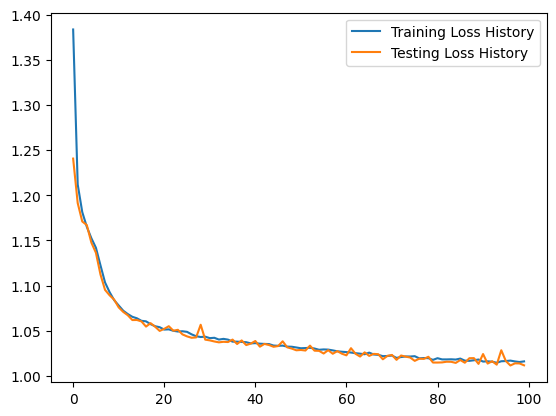

In [18]:
plt.plot(train_hist, label="Training Loss History")
plt.plot(test_hist, label="Testing Loss History")
plt.legend()
plt.show()